# DISCLAIMER

This is my third attempt to complete this lab :) The first notebook became unavailable on the third approach with T5 due to colab IO issues and versioning, so I had to start from scratch. The second notebook was for the EN-RU translation (after that I've realized that there is a typo in the description and the problem statement is RU-EN translation).

Because of slight demotivation and running out of time, some details can be missing.

## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality.

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip install subword-nmt
! pip install nltk
! pip install torchtext==0.11.0
! pip install transformers sentencepiece

  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
     ---------------------------------------- 1.5/1.5 MB 6.3 MB/s eta 0:00:00
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     -------------------------------------- 267.7/267.7 kB 8.3 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 4.6 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement torchtext==0.11.0 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0)
ERROR: No matching distribution found for torchtext==0.11.0


     ---------------------------------------- 5.8/5.8 MB 7.0 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 9.0 MB/s eta 0:00:00
     ------------------------------------- 182.4/182.4 kB 10.8 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
     ---------------------------------------- 3.3/3.3 MB 8.1 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/homeworks_advanced/Lab1_NLP/my_network.py -nc

utils file not found locally. Downloading from github.
--2022-12-04 16:37:19--  https://raw.githubusercontent.com/girafe-ai/ml-course/master/homeworks_advanced/Lab1_NLP/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     932  --.-KB/s    in 0s      

2022-12-04 16:37:20 (72.3 MB/s) - ‘utils.py’ saved [932/932]

network file not found locally. Downloading from github.
--2022-12-04 16:37:20--  https://raw.githubusercontent.com/girafe-ai/ml-course/master/homeworks_advanced/Lab1_NLP/my_network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import pandas as pd
import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9267
Unique tokens in target (en) vocabulary: 6699


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 '29',
 'соль',
 'комо',
 '―',
 'электрическая',
 'ming',
 'утренний',
 'детском',
 'таунус']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'king', 'buffets', 'catch', 'media', 'schedule', 'maraunenhof']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['laundry', 'service', 'is', 'provided', '.'], 'src': ['помимо', 'этого', ',', 'гостям', 'предоставляются', 'услуги', 'прачечной', '.']}


Let's check the length distributions:

Length distribution in Train data


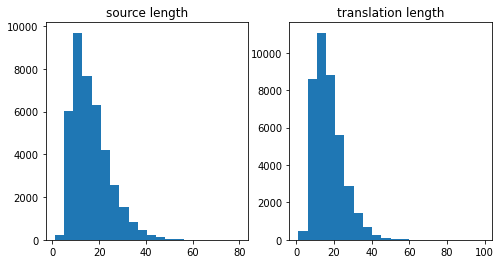

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


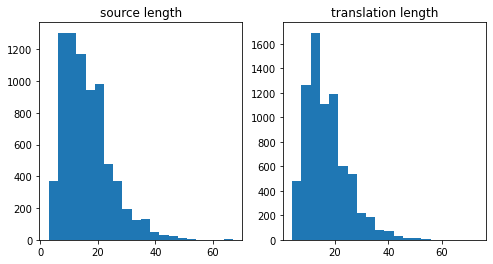

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda', index=1)

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 55x128 (GPU 1)]
	[.src]:[torch.cuda.LongTensor of size 59x128 (GPU 1)]
torch.Size([59, 128]) torch.Size([55, 128])


In [ ]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9267, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6699, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6699, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,880,299 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]

        loss = criterion(output, trg)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

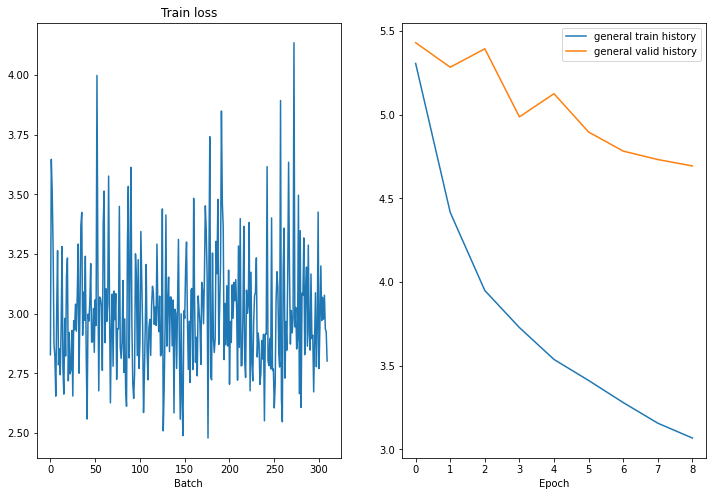

Epoch: 10 | Time: 1m 10s
	Train Loss: 2.998 | Train PPL:  20.040
	 Val. Loss: 4.710 |  Val. PPL: 111.007


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
del utils

In [ ]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: the property offers a 24 - hour front desk . .

Original: this property also features free wifi .
Generated: free wifi access . . . .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:03, 18.87it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.139920232081806

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set.
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

# Problem statement

EN-RU translation problem.

1. Reach BLEU 29 score
2. Try out 3 different models / approaches
3. Provide conclusion / summary (translation quality/complexity/training and evaluation time)

## Data preparation

To avoid crashing of the notebook one more time, I'm preparing the datasets in a custom way, making sure there wil be no versioning issues.

In [3]:
import torchtext
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
import pandas as pd

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from typing import List
from tqdm import tqdm
from transformers import MarianMTModel, MarianTokenizer, \
    AutoTokenizer, T5ForConditionalGeneration, DataCollatorForSeq2Seq
import warnings
import time
import math
import random
import sentencepiece as spm
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
# import evaluate
import logging

warnings.filterwarnings('ignore')

path_do_data = './data.txt'

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
[torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]

['Tesla T4']

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
device

device(type='cuda', index=0)

In [8]:
path_do_data = 'data.txt'
df = pd.read_csv(path_do_data, sep="\t", names=['en', 'ru'], header=None)

In [9]:
df.head()

,en,ru
0,"Cordelia Hotel is situated in Tbilisi, a 3-min...","Отель Cordelia расположен в Тбилиси, в 3 минут..."
1,At Tupirmarka Lodge you will find a 24-hour fr...,В числе удобств лоджа Tupirmarka круглосуточна...
2,"Featuring free WiFi in all areas, Naigao Xiaow...",Апартаменты Naigao Xiaowo расположены в городе...
3,Each has a TV and a private bathroom with shower.,В вашем распоряжении также телевизор и собстве...
4,Your room comes with air conditioning and sate...,Номер оснащен кондиционером и спутниковым теле...


In [10]:
# for the sake of limited resources
df['ru'] = df['ru'].apply(lambda x: x.casefold())
df['en'] = df['en'].apply(lambda x: x.casefold())

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.75, random_state=42)

In [12]:
print(f"Number of training examples: {len(df_train)}")
print(f"Number of validation examples: {len(df_val)}")
print(f"Number of testing examples: {len(df_test)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [13]:
ru_input_train = list(df_train["ru"])
ru_input_val = list(df_val["ru"])
ru_input_test = list(df_test["ru"])

en_output_train = list(df_train["en"])
en_output_val = list(df_val["en"])
en_output_test = list(df_test["en"])

## 1st model / approach

Using a custom tokenizer for the initial seq2seq model.

In [12]:
with open('sp_ru_dataset.txt', 'w') as f:
    for line in ru_input_train:
        f.write(f"{line}\n")
with open('sp_en_dataset.txt', 'w') as f:
    for line in en_output_train:
        f.write(f"{line}\n")

In [13]:
sp_dataset = 'sp_ru_dataset.txt'
flags = f"--input={sp_dataset} --model_prefix=ru_spm --vocab_size=4000" \
    "--pad_id=0 --character_coverage=1.0 --model_type=unigram --num_threads=64"
spm.SentencePieceTrainer.train(flags)
sp_ru = spm.SentencePieceProcessor()
sp_ru.load("ru_spm.model")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=sp_ru_dataset.txt --model_prefix=ru_spm --vocab_size=4000--pad_id=0 --character_coverage=1.0 --model_type=unigram --num_threads=64
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_ru_dataset.txt
  input_format: 
  model_prefix: ru_spm
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 64
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 

True

In [16]:
sp_ru.encode_as_pieces(ru_input_val[:1])

[['▁в',
  '▁районе',
  '▁популяр',
  'ен',
  '▁пеши',
  'й',
  '▁туризм',
  '.',
  '▁в',
  '▁распоряжени',
  'и',
  '▁гостей',
  '▁экскурсионно',
  'е',
  '▁бюро',
  '▁и',
  '▁круглосуточн',
  'ая',
  '▁стойка',
  '▁регистрации',
  '.']]

In [17]:
sp_dataset = 'sp_en_dataset.txt'
flags = f"--input={sp_dataset} --model_prefix=en_spm --vocab_size=3000" \
    "--pad_id=0 --character_coverage=1.0 --model_type=unigram --num_threads=64"
spm.SentencePieceTrainer.train(flags)
sp_en = spm.SentencePieceProcessor()
sp_en.load("en_spm.model")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=sp_en_dataset.txt --model_prefix=en_spm --vocab_size=3000--pad_id=0 --character_coverage=1.0 --model_type=unigram --num_threads=64
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_en_dataset.txt
  input_format: 
  model_prefix: en_spm
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 64
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 

True

In [18]:
sp_en.encode_as_pieces(en_output_val[:1])

[['▁hiking',
  '▁is',
  '▁pop',
  'ular',
  '▁in',
  '▁the',
  '▁area',
  ',',
  '▁and',
  '▁the',
  '▁hotel',
  '▁has',
  '▁a',
  '▁tour',
  '▁desk',
  '▁and',
  '▁24-',
  'hour',
  '▁front',
  '▁desk',
  '.']]

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [20]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output, (hidden, cell) = self.rnn(embedded, hidden, cell)
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0,:]
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            # top1 = output.max(1)[1]
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs

In [22]:
sp_ru.bos_id(), sp_ru.eos_id(), sp_ru.pad_id()

(1, 2, -1)

In [23]:
sp_en.bos_id(), sp_en.eos_id(), sp_en.pad_id()

(1, 2, -1)

In [24]:
def tokenize(sp, text, max_length=128):
    # return [np.array(ids) for ids in sp.encode_as_ids(text)]
    ids = sp.encode_as_ids(text)
    max_len = max_length - 2
    # max_len = max(map(len, ids))
    padded_ids = [
        [sp.bos_id()] \
        + s_[:max_len] \
        + [sp.eos_id()] \
        + [0] * (max_len - len(s_[:max_len])) \
        for s_ in ids
    ]
    return torch.tensor(padded_ids)

In [25]:
tokenized_ru_input_train = tokenize(sp_ru, ru_input_train)
tokenized_ru_input_val = tokenize(sp_ru, ru_input_val)
tokenized_ru_input_test = tokenize(sp_ru, ru_input_test)

tokenized_en_output_train = tokenize(sp_en, en_output_train)
tokenized_en_output_val = tokenize(sp_en, en_output_val)
tokenized_en_output_test = tokenize(sp_en, en_output_test)

In [26]:
tokenized_ru_input_train.shape

torch.Size([40000, 128])

In [27]:
tokenized_ru_input_val.shape

torch.Size([2500, 128])

In [28]:
tokenized_ru_input_test.shape

torch.Size([7500, 128])

In [29]:
tokenized_en_output_train.shape

torch.Size([40000, 128])

In [30]:
tokenized_en_output_val.shape

torch.Size([2500, 128])

In [31]:
tokenized_en_output_test.shape

torch.Size([7500, 128])

In [32]:
train_dataset = TensorDataset(
        tokenized_ru_input_train.to(device),
        tokenized_en_output_train.to(device)
    )
val_dataset = TensorDataset(
        tokenized_ru_input_val.to(device),
        tokenized_en_output_val.to(device)
    )
test_dataset = TensorDataset(
        tokenized_ru_input_test.to(device),
        tokenized_en_output_test.to(device)
    )

In [33]:
BATCH_SIZE = 128

torch_train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

torch_val_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size=BATCH_SIZE
)

torch_test_dataloader = DataLoader(
    test_dataset,
    sampler = RandomSampler(test_dataset),
    batch_size=BATCH_SIZE
)

In [ ]:
INPUT_DIM = sp_en.vocab_size()
OUTPUT_DIM = sp_ru.vocab_size()
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        # nn.init.uniform_(param, -1.0, 1.0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3000, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(4000, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=4000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [39]:
next(model.parameters()).is_cuda

True

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,200,416 trainable parameters


In [41]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [42]:
def draw_plot(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
    plt.legend()
    plt.show()

In [43]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch[0]
        trg = batch[1]
        optimizer.zero_grad()
        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            draw_plot(history)
    return epoch_loss / len(iterator)

In [44]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch[0]
            trg = batch[1]
            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [46]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3

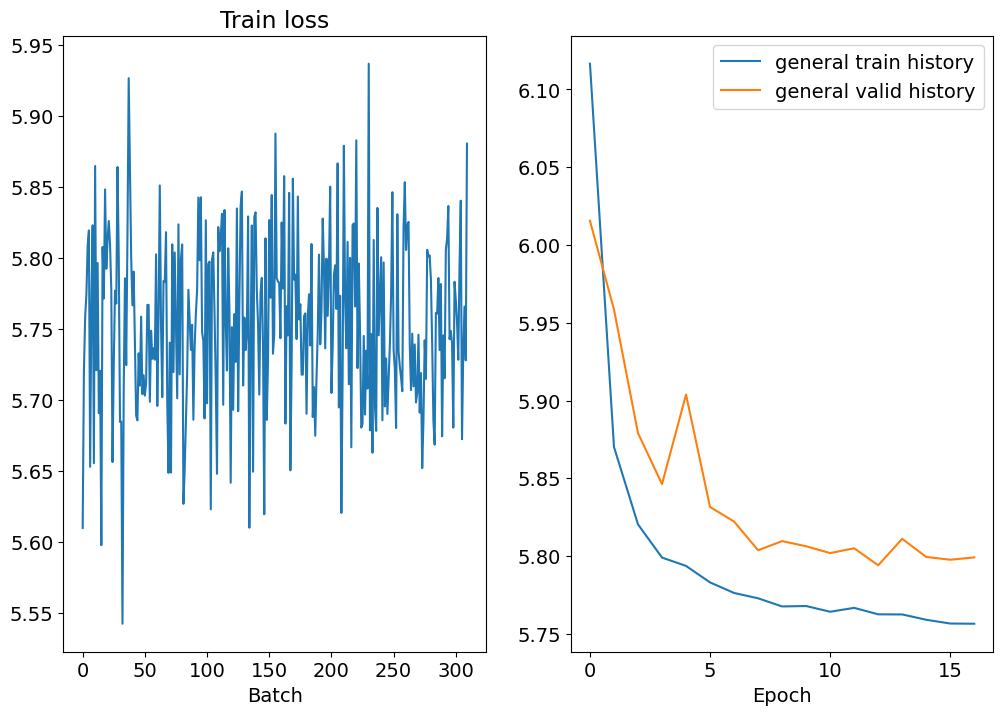

Epoch: 10 | Time: 62m 25s
	Train Loss: 5.755 | Train PPL: 315.615
	 Val. Loss: 5.801 |  Val. PPL: 330.581


In [ ]:
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, torch_train_dataloader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, torch_val_dataloader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm-model-1.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if early_stopping_counter == early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")

In [631]:
def get_text_as_pieces(x, sp):
    text = [sp.id_to_piece(token) for token in x]
    try:
        end_idx = text.index(sp.eos_id())
        text = text[:end_idx]
    except ValueError:
        pass
    return text

In [ ]:
def get_text(x, sp):
    special_token_ids = {sp_en.bos_id(), sp_en.eos_id(), sp_en.pad_id(), sp_en.unk_id()}
    text = []
    for token in x:
        if token == sp_en.eos_id():
            break
        if token not in special_token_ids:
            text.append(token)
    return sp.decode(text)

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm(enumerate(torch_test_dataloader)):

        src = batch[0]
        trg = batch[1]

        output = model(src, trg, 0) #turn off teacher forcing

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, sp_ru) for x in trg.cpu().numpy().tolist()])
        generated_text.extend([get_text(x, sp_ru) for x in output.detach().cpu().numpy().tolist()])

In [693]:
with torch.no_grad():
    hidden, cell = model.encoder(src[3])

trg_indexes = [sp_ru.bos_id()]
for i in tqdm(range(128)):
    trg_tensor = torch.tensor(trg_indexes[-1]).to(device)
    with torch.no_grad():
        output, hidden_dec, cell_dec = model.decoder(trg_tensor, hidden, cell)
    # pred_token = output.argmax(2)[:,-1].item()
    pred_token = output.argmax(0).item()
    trg_indexes.append(pred_token)
    if pred_token == sp_ru.eos_id():
        print(f"EOS token, finishing at {i}-th token.")
        break
trg_tokens = sp_ru.id_to_piece(trg_indexes)

100%|██████████| 128/128 [00:00<00:00, 779.39it/s]


In [ ]:
corpus_bleu([[s] for s in ru_output_test], generated_text) * 100

11.014577851692101

## 2d model / approach

Low-hanging fruits: using a pre-trained translation model without fine-tuning.

In [11]:
model_name = "Helsinki-NLP/opus-mt-ru-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

model.to(device)

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(62518, 512, padding_idx=62517)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(62518, 512, padding_idx=62517)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0): MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1

In [12]:
def tokenize(text, max_length=128):
    return tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt",
    )

In [13]:
def batch_translate(text: List[str], batch_size: int = 128) -> List[str]:
    inputs = tokenize(text)
    input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    res = []
    for i in tqdm(range(len(text) // batch_size + 1)):
        batch_input_ids = input_ids[i*batch_size:(i+1)*batch_size]
        batch_attention_mask = attention_mask[i*batch_size:(i+1)*batch_size]
        # translated = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        translated = model.generate(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            max_length=128
        )
        res += translated
    return res

In [16]:
%%time
translated = batch_translate(ru_input_test)

100%|██████████| 59/59 [07:21<00:00,  7.49s/it]

CPU times: user 3min 25s, sys: 3min 46s, total: 7min 11s
Wall time: 7min 23s


In [43]:
%%time
y_test_pred = []
for t in tqdm(translated):
    t = tokenizer.decode(t, skip_special_tokens=True)
    t = t.casefold()
    t = tokenizer.tokenize(t)
    y_test_pred.append(t)

100%|██████████| 7500/7500 [00:12<00:00, 598.71it/s]

CPU times: user 12.5 s, sys: 106 ms, total: 12.6 s
Wall time: 12.5 s


In [44]:
len(y_test_pred)

7500

In [45]:
refs = [[tokenizer.tokenize(s)] for s in en_output_test]

In [46]:
refs[7499:]

[[['▁q',
   'ing',
   'da',
   'o',
   '▁',
   'li',
   'ut',
   'ing',
   '▁',
   'int',
   'ern',
   'ation',
   'al',
   '▁a',
   'ir',
   'port',
   '▁',
   'is',
   '▁',
   'an',
   '▁h',
   'our',
   "'",
   '▁c',
   'ar',
   '▁j',
   'our',
   'ne',
   'y',
   '▁a',
   'w',
   'ay',
   '.']]]

In [47]:
y_test_pred[7499:]

[['▁l',
  'ut',
  'in',
  '▁c',
  'ind',
  'a',
  'o',
  '▁',
  'int',
  'ern',
  'ation',
  'al',
  '▁a',
  'ir',
  'port',
  '▁',
  'is',
  '▁',
  'an',
  '▁h',
  'our',
  "'",
  's',
  '▁d',
  'r',
  'ive',
  '.']]

In [48]:
corpus_bleu(refs, y_test_pred) * 100

38.54377618534326

## 3d model / approach

Fine-tuning T5-small.

In [14]:
tokenizer = AutoTokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [15]:
model.to(device);

In [16]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [17]:
def tokenize(src, trg):
    inputs = [example for example in src]
    model_inputs = tokenizer(inputs, 
        text_target=trg, 
        max_length=128, 
        truncation=True, 
        padding=True,
        return_tensors='pt')
    return model_inputs

In [18]:
tokenized_train = tokenize(ru_input_train, en_output_train)
tokenized_val = tokenize(ru_input_val, en_output_val)
tokenized_test = tokenize(ru_input_test, en_output_test)

In [19]:
tokenized_train['input_ids'] = tokenized_train['input_ids'].to(device)
tokenized_train['labels'] = tokenized_train['labels'].to(device)
tokenized_val['input_ids'] = tokenized_val['input_ids'].to(device)
tokenized_val['labels'] = tokenized_val['labels'].to(device)
tokenized_test['input_ids'] = tokenized_test['input_ids'].to(device)
tokenized_test['labels'] = tokenized_test['labels'].to(device)

In [20]:
class T5Dataset(Dataset):
    def __init__(self, encoding):
        self.encoding = encoding

    def __len__(self):
        return len(self.encoding['input_ids'])

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encoding['input_ids'][idx])
        target_ids = torch.tensor(self.encoding['labels'][idx])
        return {"input_ids": input_ids, "labels": target_ids}

In [21]:
train_dataset = T5Dataset(tokenized_train)
val_dataset = T5Dataset(tokenized_val)
test_dataset = T5Dataset(tokenized_test)

In [22]:
BATCH_SIZE = 64

torch_train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

torch_val_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size=BATCH_SIZE
)

torch_test_dataloader = DataLoader(
    test_dataset,
    sampler = RandomSampler(test_dataset),
    batch_size=BATCH_SIZE
)

In [23]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [24]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch['input_ids']
            trg = batch['labels']
            # output = model(src, trg)
            # loss = criterion(output, trg)
            loss = model(input_ids=src, labels=trg).loss
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [25]:
def train(model, iterator, optimizer, criterion, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(torch_train_dataloader):
        src = batch['input_ids']
        trg = batch['labels']

        optimizer.zero_grad()
        loss = model(input_ids=src, labels=trg).loss
        # loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)

In [26]:
train_history = []
valid_history = []
N_EPOCHS = 10
best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3

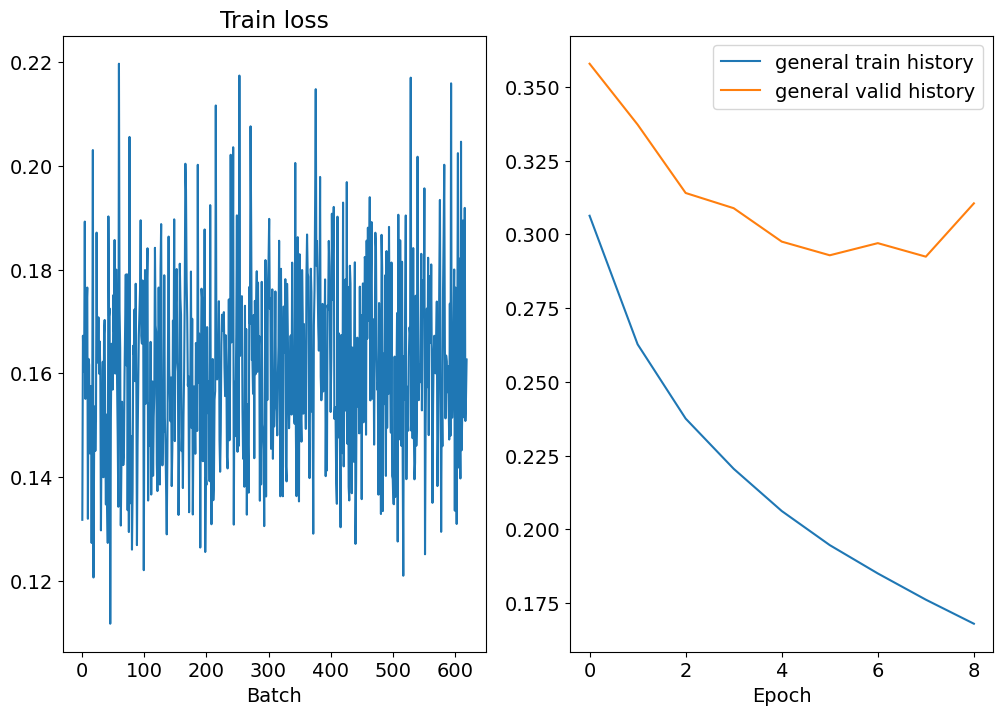

Epoch: 10 | Time: 10m 40s
	Train Loss: 0.161 | Train PPL:   1.175
	 Val. Loss: 0.289 |  Val. PPL:   1.335


In [29]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, torch_train_dataloader, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model, torch_val_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 't5_small.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if early_stopping_counter == early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")

In [30]:
preds = []
model.eval()
with torch.no_grad():
    l = len(tokenized_test['input_ids'])
    bs = 128
    for i in tqdm(range(l // bs + 1)):
        pred = model.generate(tokenized_test['input_ids'][i*bs:(i+1)*bs], max_length=128)
        pred = pred.cpu().numpy().tolist()
        preds += pred

100%|██████████| 59/59 [00:57<00:00,  1.03it/s]


In [31]:
len(preds)

7500

In [37]:
refs = [[tokenizer.tokenize(s)] for s in en_output_test]

In [48]:
refs[1]

[['▁there',
  '▁is',
  '▁',
  'a',
  '▁security',
  '▁desk',
  '▁by',
  '▁each',
  '▁entrance',
  '▁and',
  '▁2',
  '▁elegant',
  '▁elevator',
  's',
  '▁for',
  '▁guests',
  "'",
  '▁use',
  '.']]

In [33]:
res = tokenizer.batch_decode(preds, skip_special_tokens=True)

In [43]:
hyps = [tokenizer.tokenize(s) for s in res]

In [49]:
hyps[1]

['▁',
 'o',
 'h',
 'ran',
 '▁is',
 '▁located',
 '▁next',
 '▁to',
 '▁each',
 '▁door',
 ',',
 '▁and',
 '▁the',
 '▁building',
 '▁has',
 '▁2',
 '▁elegant',
 '▁lift',
 's',
 '.']

In [45]:
corpus_bleu(refs, hyps) * 100

42.96412260585379

## 4th model / approach

Improvement of the third approach:
- reduced LR, 
- additional training epochs
- added prompting "translate russian to english: "

In [51]:
def tokenize(src, trg):
    inputs = ["translate russian to english: " + example for example in src]
    model_inputs = tokenizer(inputs, 
        text_target=trg, 
        max_length=128, 
        truncation=True, 
        padding=True,
        return_tensors='pt')
    return model_inputs

In [52]:
tokenized_train = tokenize(ru_input_train, en_output_train)
tokenized_val = tokenize(ru_input_val, en_output_val)
tokenized_test = tokenize(ru_input_test, en_output_test)

In [53]:
tokenized_train['input_ids'] = tokenized_train['input_ids'].to(device)
tokenized_train['labels'] = tokenized_train['labels'].to(device)
tokenized_val['input_ids'] = tokenized_val['input_ids'].to(device)
tokenized_val['labels'] = tokenized_val['labels'].to(device)
tokenized_test['input_ids'] = tokenized_test['input_ids'].to(device)
tokenized_test['labels'] = tokenized_test['labels'].to(device)

In [54]:
train_dataset = T5Dataset(tokenized_train)
val_dataset = T5Dataset(tokenized_val)
test_dataset = T5Dataset(tokenized_test)

In [55]:
BATCH_SIZE = 64

torch_train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

torch_val_dataloader = DataLoader(
    val_dataset,
    sampler = RandomSampler(val_dataset),
    batch_size=BATCH_SIZE
)

torch_test_dataloader = DataLoader(
    test_dataset,
    sampler = RandomSampler(test_dataset),
    batch_size=BATCH_SIZE
)

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(ignore_index=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.2, patience=1, threshold=0.00001
)

In [57]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch['input_ids']
            trg = batch['labels']
            # output = model(src, trg)
            # loss = criterion(output, trg)
            loss = model(input_ids=src, labels=trg).loss
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [58]:
def train(model, iterator, optimizer, criterion, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(torch_train_dataloader):
        src = batch['input_ids']
        trg = batch['labels']

        optimizer.zero_grad()
        loss = model(input_ids=src, labels=trg).loss
        # loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)

In [ ]:
train_history = []
valid_history = []
N_EPOCHS = 10
best_valid_loss = float('inf')
early_stopping_counter = 0
early_stopping_criteria = 3

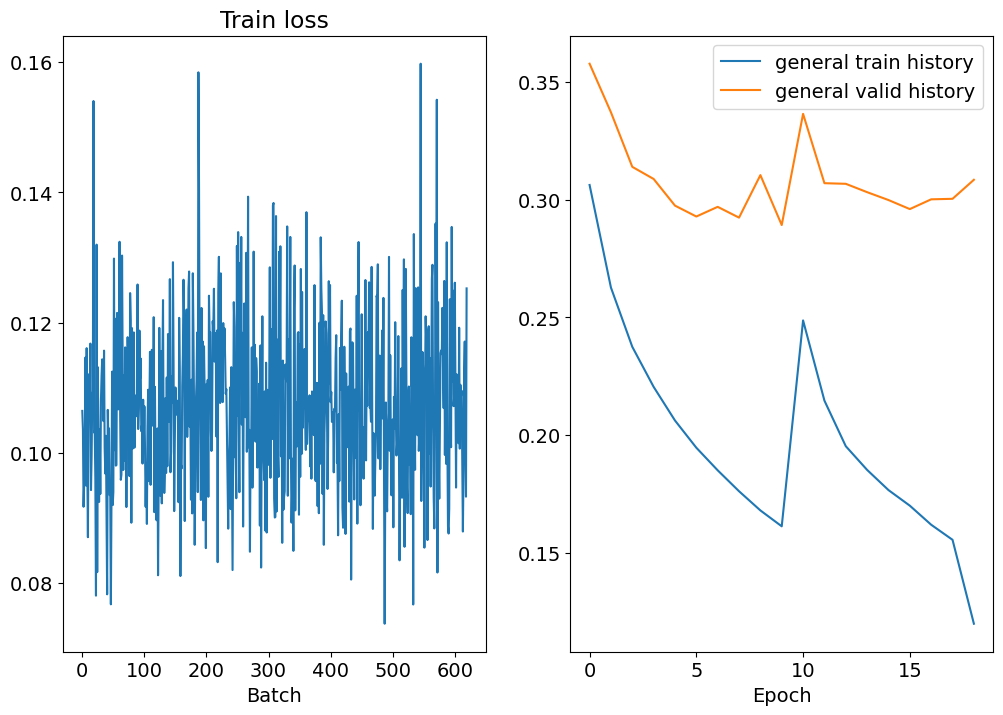

Epoch: 10 | Time: 10m 35s
	Train Loss: 0.107 | Train PPL:   1.113
	 Val. Loss: 0.309 |  Val. PPL:   1.362


In [59]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, torch_train_dataloader, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model, torch_val_dataloader, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    scheduler.step(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 't5_small.pt')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if early_stopping_counter == early_stopping_criteria:
        print(f"Early stopping, reached limit: {early_stopping_criteria}")

In [68]:
preds = []
model.eval()
with torch.no_grad():
    l = len(tokenized_test['input_ids'])
    bs = 128
    for i in tqdm(range(l // bs + 1)):
        pred = model.generate(tokenized_test['input_ids'][i*bs:(i+1)*bs], max_length=128)
        pred = pred.cpu().numpy().tolist()
        preds += pred

100%|██████████| 59/59 [00:58<00:00,  1.00it/s]


In [69]:
len(preds)

7500

In [70]:
refs = [[tokenizer.tokenize(s)] for s in en_output_test]

In [71]:
refs[1]

[['▁there',
  '▁is',
  '▁',
  'a',
  '▁security',
  '▁desk',
  '▁by',
  '▁each',
  '▁entrance',
  '▁and',
  '▁2',
  '▁elegant',
  '▁elevator',
  's',
  '▁for',
  '▁guests',
  "'",
  '▁use',
  '.']]

In [72]:
res = tokenizer.batch_decode(preds, skip_special_tokens=True)

In [73]:
hyps = [tokenizer.tokenize(s) for s in res]

In [74]:
hyps[1]

['▁the',
 '▁property',
 '▁is',
 '▁located',
 '▁right',
 '▁next',
 '▁to',
 '▁each',
 '▁entrance',
 '▁of',
 '▁',
 'o',
 'h',
 'ran',
 ',',
 '▁in',
 '▁the',
 '▁same',
 '▁building',
 '▁as',
 '▁2',
 '▁elegant',
 '▁elevator',
 's',
 '.']

In [75]:
corpus_bleu(refs, hyps) * 100

44.740976056413956

## Summary

In [ ]:
# TODO: description